In [1]:
def get_res(zoom, latitude):
    return 156543.03 * math.cos(math.pi / 180 * latitude) / (2 ** zoom)

In [19]:
get_res(16,15)

2.307265557900153

In [1]:
import math
import random
import os
import numpy as np
import pandas as pd
#from osgeo import gdal, osr
from tqdm.notebook import tqdm
import sklearn

import requests
import matplotlib.pyplot as plt
from io import BytesIO
import logging
import time

In [2]:
BASE_DIR = '..'
COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
PROCESSED_DIR = os.path.join(BASE_DIR, 'data', 'processed')
# can try using the google downloader, in which case change this to be your google api token
ACCESS_TOKEN_DIR = os.path.join(BASE_DIR, 'google_api_key.txt')

RANDOM_SEED = 7 # for reproducibility

# each cluster must have AT LEAST this many images after doing nightlights processing
MIN_IMAGES_PER_CLUSTER = 10

In [3]:
import sys
sys.path.append(BASE_DIR)
from funcs import create_space

## Download Images

In [4]:
df_download = pd.read_csv(os.path.join(PROCESSED_DIR, 'image_download_locs.csv'))

In [5]:
from google_satellite import GoogleDownloader

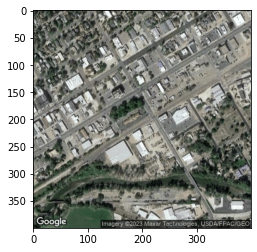

In [6]:
lat = 38.441332
lon = -105.234751

access = open(ACCESS_TOKEN_DIR, 'r').readlines()[0].strip()
pd = GoogleDownloader(access)
plt.imshow(pd.download(lat, lon, zoom=16))

In [7]:
def download_images(df):
    """
    Download images using a pandas DataFrame that has "image_lat", "image_lon", "image_name", "country" as columns
    
    Saves images to the corresponding country's images folder

    """
    access = None
    with open(ACCESS_TOKEN_DIR, 'r') as f:
        access = f.readlines()[0]
    imd = GoogleDownloader(access)
    num_retries = 20
    wait_time = 0.1 # seconds

    # drops what is already downloaded
    already_downloaded = os.listdir(os.path.join(COUNTRIES_DIR, 'malawi_2016', 'images')) + \
                        os.listdir(os.path.join(COUNTRIES_DIR, 'ethiopia_2016', 'images')) + \
                        os.listdir(os.path.join(COUNTRIES_DIR, 'nigeria_2016', 'images'))
    already_downloaded =  list(set(already_downloaded).intersection(set(df['image_name'])))
    print('Already downloaded ' + str(len(already_downloaded)))
    df = df.set_index('image_name').drop(already_downloaded).reset_index()
    print('Need to download ' + str(len(df)))
    for _, r in tqdm(df.iterrows(), total=df.shape[0]):
        lat = r.image_lat
        lon = r.image_lon
        name = r.image_name
        country_dir = None
        if r.country == 'mw':
            country_dir = 'malawi_2016'
        elif r.country == 'eth':
            country_dir = 'ethiopia_2016'
        elif r.country == 'ng':
            country_dir = 'nigeria_2016'
        else:
            print(f"unrecognized country: {r.country}")
            raise ValueError()
        image_save_path = os.path.join(COUNTRIES_DIR, country_dir, 'images', r.image_name)
        try:
            im = imd.download(lat, lon, zoom=16)
            if (type(im) == str and im == 'RETRY') or im is None:
                resolved = False
                for _ in range(num_retries):
                    time.sleep(wait_time)
                    im = imd.download(lat, lon, zoom=16)
                    if (type(im) == str and im == 'RETRY') or im is None:
                        continue
                    else:
                        plt.imsave(image_save_path, im)
                        resolved = True
                        break
                if not resolved:
                    print(f'Could not download {lat}, {lon} despite several retries and waiting')
                    continue
                else:
                    pass
            else:
                # no issues, save according to naming convention
                plt.imsave(image_save_path, im)

        except Exception as e:
            logging.error(f"Error-could not download {lat}, {lon}", exc_info=True)
            continue

In [9]:
download_images(df_download)

Already downloaded 33360
Need to download 0


0it [00:00, ?it/s]